In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool
from torch_geometric.utils import remove_self_loops
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, auc
import random

In [2]:
# Read from csv (without second list in daughter columns - see data_loading.ipynb)
train_df = pd.read_csv('new_train_data.csv')
test_df = pd.read_csv('new_test_data.csv')

In [3]:
# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)


Data preprocessing

In [4]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Gauss']
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Gauss']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Duplicate single features for each node and convert strings into float lists
train_df = duplicate(train_df, ['Jet0_PT', 'Jet0_Eta'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_PT', 'Jet1_Eta'], 'Jet1_nDaughters')
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Cut out some data for quicker runs
cut_train_df = pd.concat([train_df.head(1000), train_df.iloc[100000:101000]]) 
cut_test_df = pd.concat([test_df.head(1000), test_df.iloc[100000:101000]])

Test - create gaussian distribution around 10 for background and 25 for signal (std = 5) to see if it picks up on it

In [5]:
# Create Gauss values for each daughter based on IsB column

def generate_gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def generate_gaussian_list(row, mean1, mean2, std_dev):
    num_daughters = int(row['Jet0_nDaughters'] if 'Jet0_nDaughters' in row else row['Jet1_nDaughters'])
    mean = mean1 if row['IsB'] == 1 else mean2
    return [generate_gaussian(mean, std_dev) for _ in range(num_daughters)]

# Apply the function to create the new 'Gauss' column
cut_train_df['Gauss'] = cut_train_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)
cut_test_df['Gauss'] = cut_test_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)

# Print some results to verify
print("Training set:")
print(cut_train_df[['IsB', 'Jet0_nDaughters', 'Gauss']].head())
print("\nTest set:")
print(cut_test_df[['IsB', 'Jet1_nDaughters', 'Gauss']].head())

Training set:
   IsB  Jet0_nDaughters                                              Gauss
0    0               14  [24.43926992723242, 33.66752790469023, 26.9699...
1    0               18  [40.11544794837157, 33.17986186326036, 20.9802...
2    0                9  [22.665725229506155, 18.885590841112997, 19.00...
3    1               15  [6.101389316951794, 8.325559673835686, 13.7878...
4    0               16  [22.00225810370956, 28.362525396402287, 27.497...

Test set:
   IsB  Jet1_nDaughters                                              Gauss
0    0               18  [31.570517499392622, 19.59486875625968, 25.223...
1    1               26  [8.083371727998292, 22.242257409420986, 6.5336...
2    0               13  [26.131152274022426, 22.868917775545295, 19.80...
3    0               11  [24.228023223620244, 27.337045309249024, 27.39...
4    1               19  [-1.510220594487869, 11.692747961050612, 9.835...


In [6]:
cut_train_df.Gauss

0         [24.43926992723242, 33.66752790469023, 26.9699...
1         [40.11544794837157, 33.17986186326036, 20.9802...
2         [22.665725229506155, 18.885590841112997, 19.00...
3         [6.101389316951794, 8.325559673835686, 13.7878...
4         [22.00225810370956, 28.362525396402287, 27.497...
                                ...                        
100995    [8.74168189268882, 12.625057781995853, 10.9834...
100996    [22.66877259026648, 21.820913601994842, 9.7395...
100997    [11.358046134856895, 14.188321164846094, 7.549...
100998    [15.730512303555548, 6.649857117636847, 6.0895...
100999    [26.53003050314286, 24.159017769142718, 21.960...
Name: Gauss, Length: 2000, dtype: object

In [7]:
cut_train_df.IsB

0         0
1         0
2         0
3         1
4         0
         ..
100995    1
100996    0
100997    1
100998    1
100999    0
Name: IsB, Length: 2000, dtype: int64

In [30]:
# Create graphs for each jet
def create_data_objects(df, features_array):
    data_objects = []
    for idx, jet_features in enumerate(features_array):

        num_classes = 2 # binary classification
        x = torch.tensor(jet_features, dtype=torch.float)
        num_nodes = x.size(0)

        # Fully connected edges
        edge_index = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                edge_index.append([i, j])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        edge_index, _ = remove_self_loops(data.edge_index)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(cut_train_df, train_f_cols)
test_features = node_features(cut_test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(cut_train_df, train_features)
test_data = create_data_objects(cut_test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

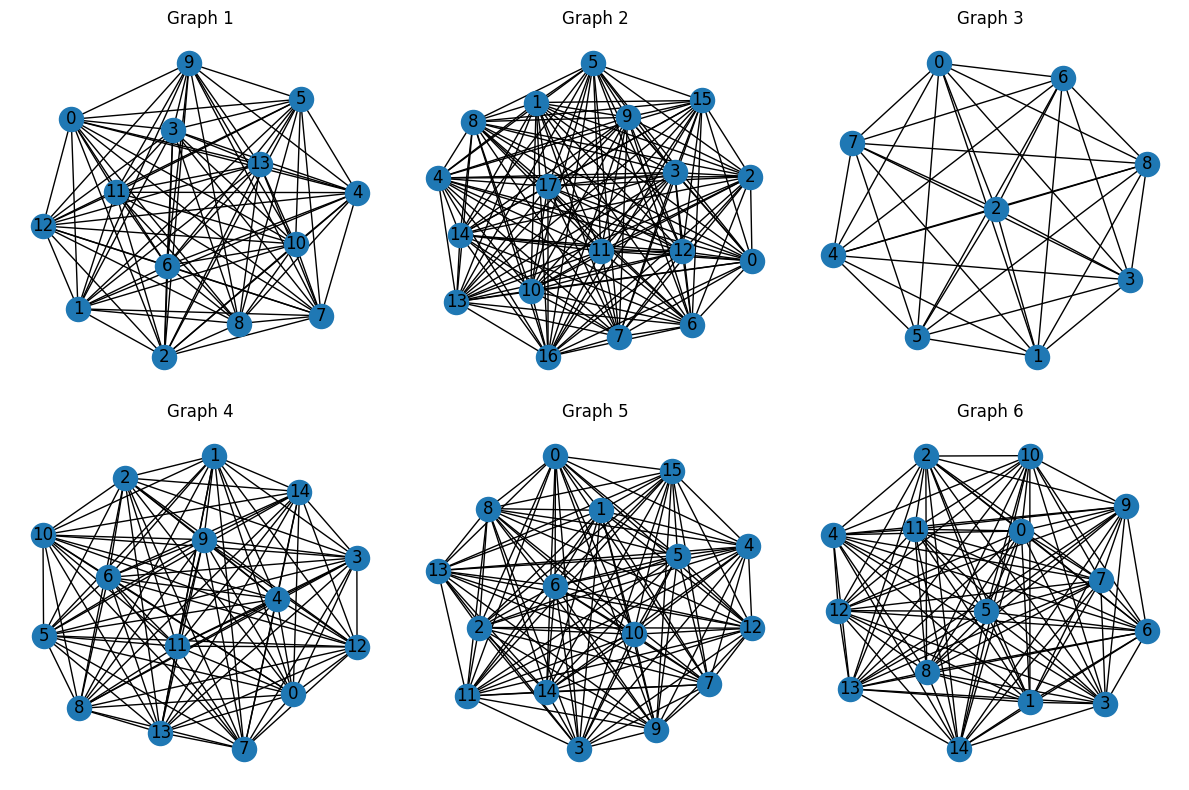

In [71]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], with_labels=True)
    
    axes[i].set_title(f"Graph {i+1}")

plt.tight_layout()
plt.show()

In [9]:
cut_train_df.Gauss

0         [24.43926992723242, 33.66752790469023, 26.9699...
1         [40.11544794837157, 33.17986186326036, 20.9802...
2         [22.665725229506155, 18.885590841112997, 19.00...
3         [6.101389316951794, 8.325559673835686, 13.7878...
4         [22.00225810370956, 28.362525396402287, 27.497...
                                ...                        
100995    [8.74168189268882, 12.625057781995853, 10.9834...
100996    [22.66877259026648, 21.820913601994842, 9.7395...
100997    [11.358046134856895, 14.188321164846094, 7.549...
100998    [15.730512303555548, 6.649857117636847, 6.0895...
100999    [26.53003050314286, 24.159017769142718, 21.960...
Name: Gauss, Length: 2000, dtype: object

In [10]:
train_features[0][0][31] # Gaussian features are included in the training data

24.43926992723242

In [79]:
for data in train_loader:
    print(f"x shape: {data.x.shape}") # [num_nodes, num_features]
    print(f"edge_index shape: {data.edge_index.shape}") # [2, num_edges] fully connected
    print(f"y: {data.y}") # labels
    print(f"y shape: {data.y.shape}")
    print(f"batch shape: {data.batch.shape}") #num nodes in this batch
    print("###########################################")

x shape: torch.Size([481, 32])
edge_index shape: torch.Size([2, 7840])
y: tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])
y shape: torch.Size([32])
batch shape: torch.Size([481])
###########################################
x shape: torch.Size([421, 32])
edge_index shape: torch.Size([2, 5896])
y: tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
y shape: torch.Size([32])
batch shape: torch.Size([421])
###########################################
x shape: torch.Size([435, 32])
edge_index shape: torch.Size([2, 6350])
y: tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.])
y shape: torch.Size([32])
batch shape: torch.Size([435])
###########################################
x shape: torch.Size([491, 32])
edge_inde

In [36]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(len(train_f_cols), 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = Linear(64, 1)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

In [70]:
# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train():
    model.train()
    for data in train_loader:
        #print(f"x:  {data.x}")
        #print(f"x shape:  {data.x.shape}")
        #print(f"Edge index:  {data.edge_index}")
        #print(f"Edge index shape:  {data.edge_index.shape}")
        #print(f"y:  {data.y}")
        #print(f"y shape:  {data.y.shape}")
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        #print(out)
        loss = criterion(out, data.y.float())
        #print(loss)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        
    return loss.item()

def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            #print(out)
            pred = (torch.sigmoid(out) > 0.5).float()
            #print(pred)
            correct = (pred.squeeze() == data.y.float()).sum().item()
            #print(correct)
            total_correct += correct
            #print(total_correct)
            total_samples += len(data.y)
            #print(total_samples)
    return total_correct / total_samples

num_epochs = 10
loss_values = []
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    #scheduler.step(train_loss)

Epoch: 001, Loss: 290400.8125, Train Acc: 0.5315, Test Acc: 0.5100
Epoch: 002, Loss: 295945.5000, Train Acc: 0.5315, Test Acc: 0.5040
Epoch: 003, Loss: 220934.5625, Train Acc: 0.5065, Test Acc: 0.4965
Epoch: 004, Loss: 225800.5469, Train Acc: 0.5250, Test Acc: 0.5235
Epoch: 005, Loss: 84325.5703, Train Acc: 0.5235, Test Acc: 0.5140
Epoch: 006, Loss: 145424.5938, Train Acc: 0.5345, Test Acc: 0.5275
Epoch: 007, Loss: 37299.5195, Train Acc: 0.5270, Test Acc: 0.5100
Epoch: 008, Loss: 30093.4355, Train Acc: 0.4955, Test Acc: 0.5060
Epoch: 009, Loss: 12792.7617, Train Acc: 0.5310, Test Acc: 0.4950
Epoch: 010, Loss: 1850.6200, Train Acc: 0.5275, Test Acc: 0.5105


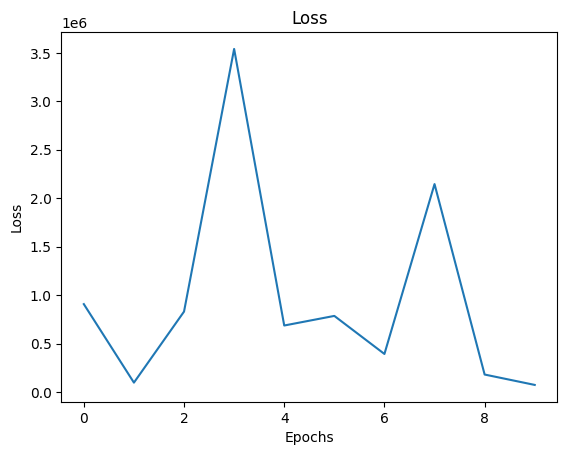

In [69]:
# Plot of loss for every training epoch
plt.plot(loss_values)
plt.title('Loss')
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [80]:
# Check gradients (exploding or vanishing)
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()
    print('Grad norms:')
        
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

check_gradients()

Grad norms:
    conv1.bias: 0.000699
    conv1.lin.weight: 788331.562500
    conv2.bias: 0.001220
    conv2.lin.weight: 647659.187500
    lin.weight: 2527784.250000
    lin.bias: 0.176348


Compute ROC Curve and AUC

In [22]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [23]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

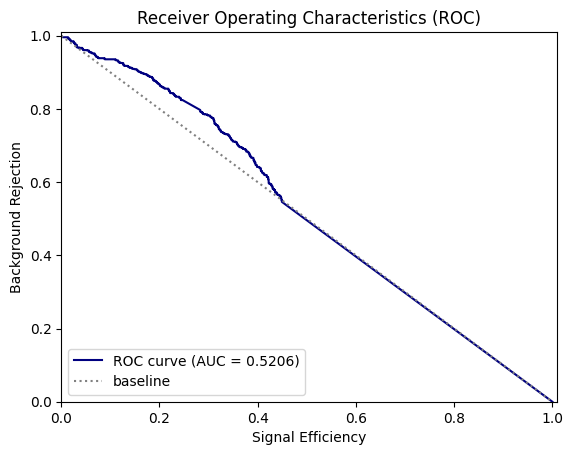

In [24]:
# Plot ROC Curve and show AUC
plt.plot(sig_eff, back_rej, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.show()

Old Method for creating data object - incorrectly adds features

In [ ]:
# Creates list of node features (float) - features[x][y], x = row index, y = index of feature column
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# Creates a data object of each df
def create_data_object(df, features_cols):
    
    df = df.sample(frac=1).reset_index(drop=True) # shuffles data before creating data object
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        
    return data_list